In [113]:
import sys
sys.path.append(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\paper\pattern_stim_code\analysis_packages')
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import time
import pickle as pkl
import importlib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import phase_analysis
import PGanalysis

## This notebook contains code to generate Figure 1

In [114]:
# set the target directory for figure 1 phase experiment data 
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_stats')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_stats'

### First, lets plot some rasters of example stimulation-phase-tuned cells 

In [115]:
# define data paths
raster_array_path  = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\raster_data\230407.npy'
psth_path = r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\paper\data\230407.npy'
mtrigger_path =  r'Z:\robin\expt_sets\pattern_stim\recordings\230407\2023-04-07_14-57-28\experiment1\recording1\continuous\Rhythm_FPGA-100.0\230407_mtrigger.dat'
expt_metadata_path = r'Z:\robin\expt_sets\pattern_stim\metadata\230407\P162_2023_4_7_17253_fullexpt'
hilbert_transformed_resp_path = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\resp_data\230407.npy'

In [4]:
# open files
trial_type_raster_array = np.load(raster_array_path, allow_pickle = True)
mtrigger_array = PGanalysis.get_events(mtrigger_path)
hilbert_transformed_resp_array = np.load(hilbert_transformed_resp_path, allow_pickle = True)
with open(expt_metadata_path, 'rb') as f:
    expt_metadata = pkl.load(f)

In [5]:
# get the trial type indices, the time of each trial, and the respiration phase-bin in which each trial occurred
trial_type_indices = phase_analysis.get_trial_type_indices(expt_metadata)
frame_on_time_s = phase_analysis.get_frame_on_time_s(mtrigger_array)
bin_indices_all, bins = phase_analysis.get_bin_indices(trial_type_indices, expt_metadata, frame_on_time_s, hilbert_transformed_resp_array,  bin_width = 36)

meta NOT subset; don't know how to subset; dropped


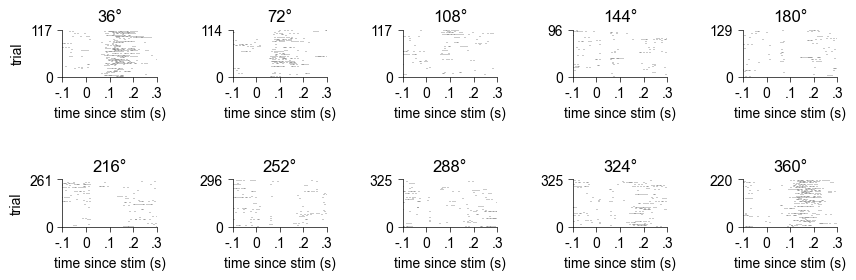

In [96]:
# plot example cell rasters 
cell = 13
stim = 1
phase_analysis.plot_phase_binned_rasters(trial_type_raster_array, bin_indices_all, cell, stim, axis_width = .4964)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_rasters_cell13_stim1.pdf', bbox_inches = 'tight')

### Next, lets quantify the proportion of cells that exhibit this stimulation-phase-tuning. 

### first, we will load the phase stats data

In [116]:
# load the phase experiment data dictionaries 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    all_phase_expts.append(phase_expt)

In [117]:
# concatenate this set of fields using the dict_key_concatenator. We will use these concatenated fields in later analyses. 
dict_keys = ['Kruskal_pval_thresh', 'Mann_Whitney_responsive_cell_bins', 'all_stim_resp_pref_phase', 'all_stim_time_to_50', 'stimulation_phase_preference']
concat_dict = {}
for key in dict_keys:
    concat_dict[key] = phase_analysis.dict_key_concatenator(all_phase_expts, key)

In [118]:
stimulation_phase_preference = concat_dict['stimulation_phase_preference']
all_stim_rise_times = concat_dict['all_stim_time_to_50']
all_stim_resp_pref_phase = concat_dict['all_stim_resp_pref_phase']

In [119]:
# calculation proportion of cells significantly activated by each spot
all_spot_activated = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # for each spot, if there is a bin in which the cell is significantly activated, count the cell as activated by that spot.
            activated_count = len(np.where((stim_activated_thresh[stim,:]>0))[0])
            all_count = len(stim_activated_thresh[stim,:])
            # calculate the proportion of cells that are significantly activated by each spot. 
            all_spot_activated.append((activated_count/all_count)*100)

### determine what percentage of significantly activated cells are tuned to stimulation phase

In [120]:
all_spot_tuned_total = []
all_spot_tuned_responsive = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # count cells that are both significantly activated and significantly tuned. 
            activated_tuned_count = len(np.where((expt['Kruskal_pval_thresh'][stim,:]>0)&(stim_activated_thresh[stim,:]>0))[0])
            all_count = len((stim_activated_thresh[stim,:]>0))
            all_activated = len(np.where(stim_activated_thresh[stim,:]>0)[0])
            # get the percentage of total cells that are both activated and tuned
            all_spot_tuned_total.append((activated_tuned_count/all_count)*100)
            # get the percentage of significantly activated cells that are tuned. 
            all_spot_tuned_responsive.append((activated_tuned_count/all_activated)*100)

meta NOT subset; don't know how to subset; dropped


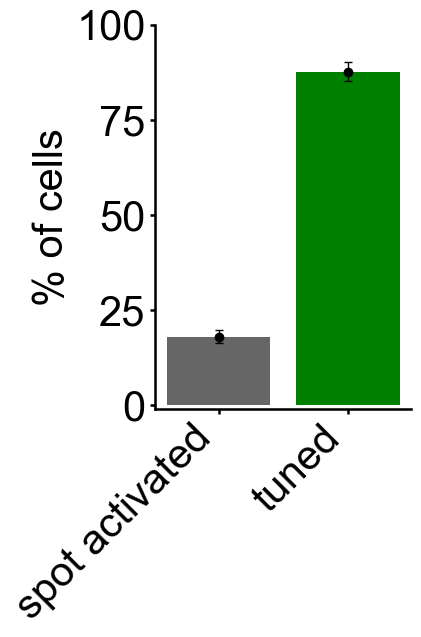

In [121]:
# plot percentage of significantly activated cells (mann whitney U p < .0025) that are tuned (kruskal-wallis p<.01)
color = [[.4,.4,.4],'g']
plt.bar([0,1], [np.mean(all_spot_activated), np.mean(all_spot_tuned_responsive)], color = color)
plt.ylim(-1,100)
plt.yticks([0,25,50,75,100])
plt.ylabel('% of cells')
CI_total = np.mean(all_spot_activated) -st.t.interval(alpha=0.95, df=len(all_spot_activated)-1, loc=np.mean(all_spot_activated), scale=st.sem(all_spot_activated))[0]
CI_responsive = np.mean(all_spot_tuned_responsive) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive))[0]
plt.xticks([0,1], labels = ['spot activated', 'tuned'], rotation = 45, ha = 'right')
plt.errorbar([0,1], [np.mean(all_spot_activated), np.mean(all_spot_tuned_responsive)], yerr = [CI_total, CI_responsive], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\percent_cells_activated_tuned.pdf', bbox_inches = 'tight')

In [122]:
print('Mean proportion of cells significantly activated by a given spot in at least one bin = ' + str(np.mean(all_spot_activated)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_activated)-1, loc=np.mean(all_spot_activated), scale=st.sem(all_spot_activated))
print('95% confidence interval = ' + str(np.mean(all_spot_activated) - CI[0]))

Mean proportion of cells significantly activated by a given spot in at least one bin = 17.949019242343358
95% confidence interval = 1.7177511587573768


In [123]:
print('Mean percentage of all responsive cells that are tuned = ' + str(np.mean(all_spot_tuned_responsive)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive)) 
print('95% confidence interval = ' + str(np.mean(all_spot_tuned_responsive) - CI[0]))

Mean percentage of all responsive cells that are tuned = 87.61345718628384
95% confidence interval = 2.526080558762004


#### Plot some example tuning curves across spots

In [15]:
tuning = np.load(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning\230407.npy', allow_pickle = True)[0]

meta NOT subset; don't know how to subset; dropped


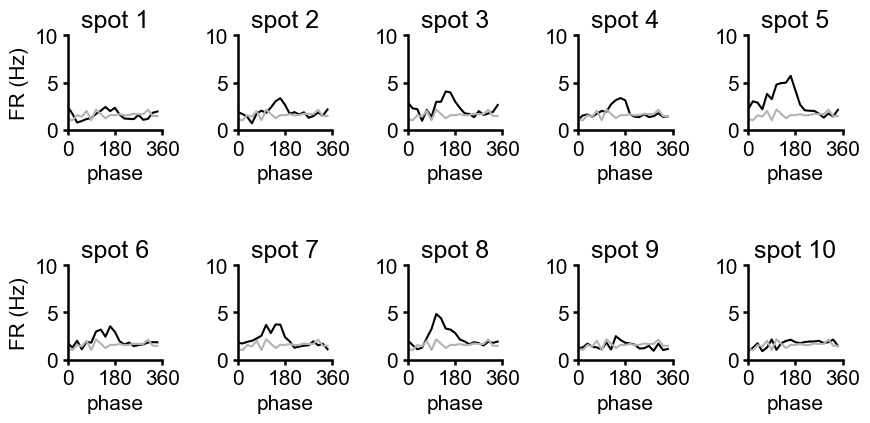

In [41]:
cell = 70
phase_analysis.plot_spot_tuning_curves(tuning, cell, ylim = 10)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_curves_cell70.pdf', bbox_inches = 'tight')

In [124]:
# Load the tuning curves for all cell-stim pairs
expt_list_tuning = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning')
target_dir_tuning = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\phase_tuning'

all_phase_tuning = []
for expt in expt_list_tuning:
    load_path = os.path.join(target_dir_tuning, expt)
    phase_tuning = np.load(load_path,allow_pickle = True)[0]
    all_phase_tuning.append(phase_tuning)

# concatenate tuning curves for all cells across experiments 
all_phase_tuning_concat = all_phase_tuning[0]
for tun in all_phase_tuning[1:]:
    all_phase_tuning_concat = np.concatenate((all_phase_tuning_concat, tun), axis = 2)

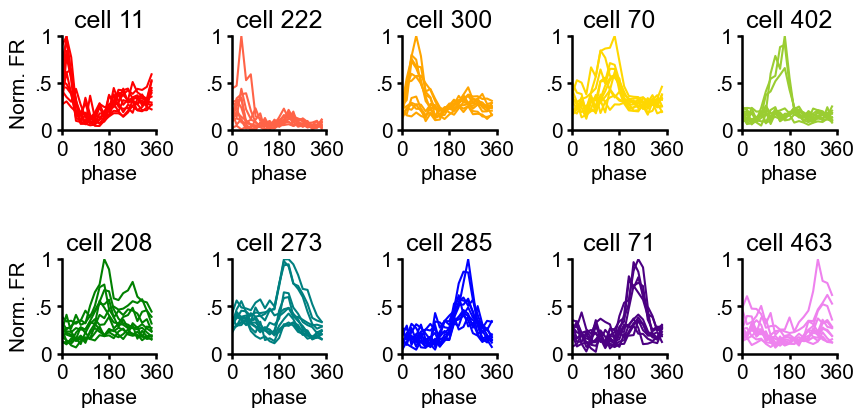

In [133]:
# Plot a set of example cell-spot pairs with responses spanning the sniff cycle 
plt.figure(figsize = (10,30))
cells = [11,222,300,70,402,208,273,285,71,463]
colors = ['red', 'tomato','orange','gold','yellowgreen','green','teal','blue','indigo','violet']
phases = np.arange(0,360,18)
for cell_n, cell in enumerate(cells):
    plt.subplot(11,5,cell_n+1)
    for stim in range(all_phase_tuning_concat.shape[0]):
        plt.plot(phases,all_phase_tuning_concat[stim,:,cell]/np.max(all_phase_tuning_concat[:,:,cell]),color = colors[cell_n])
    #plt.plot(phases,tuning[0,:,cell]/np.max(tuning[:,:,cell]),color = 'k')
    plt.ylim(0,1)
    plt.xlim(0,360)
    plt.xticks([0,180,360])
    plt.yticks([0,.5,1], labels = ['0','.5','1'])
    plt.title('cell ' + str(cell))
    plt.xlabel('phase')
    if (cell_n == 0) or (cell_n == 5):
        plt.ylabel('Norm. FR')
    PGanalysis.axis_fixer(ratio = 1, size = 15)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_tuned_cells_rainbow.pdf', bbox_inches = 'tight')

In [125]:
# get the tuning curves for all significantly activating spots for all cells 
n_cells = all_phase_tuning_concat.shape[2]
all_responsive_spot_tuning_curves = []
for cell in range(n_cells):
    # pull out spots that significantly activate the cell (a non-nan stimulation phase preference)
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves = all_phase_tuning_concat[responsive_spots,:,cell]
        all_responsive_spot_tuning_curves.append(responsive_spot_tuning_curves)

In [129]:
# flatten the list so we have an n_cell_spot_pairs x n_bins matrix
all_responsive_spot_tuning_curves_flat = np.array([spot for cell in all_responsive_spot_tuning_curves for spot in cell])
# normalize the tuning curves
all_stim_tuning_ravel_norm = all_responsive_spot_tuning_curves_flat/np.max(all_responsive_spot_tuning_curves_flat,1)[:,None]

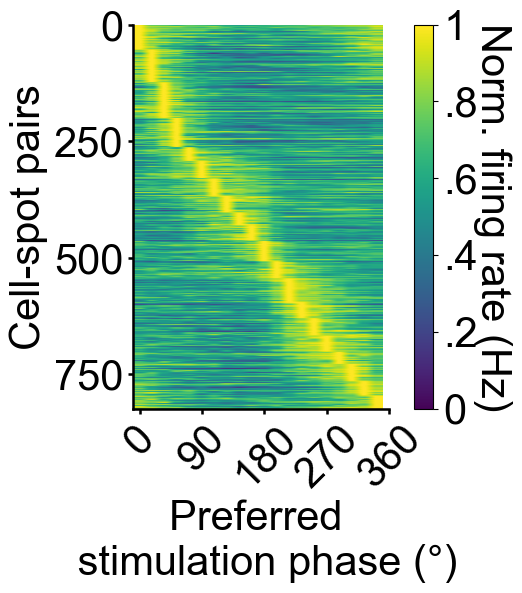

In [131]:
# plot the sorted tuning curves 
idx = np.argsort(np.argmax(all_stim_tuning_ravel_norm,1))
fig = plt.imshow(all_stim_tuning_ravel_norm[idx],aspect = 'auto')
plt.xticks(np.arange(0,25,5), labels = [str(x) for x in np.arange(0,450,90)], rotation = 45)
plt.clim(0,1)
plt.xlabel('Preferred \n stimulation phase (°)')
plt.ylabel('Cell-spot pairs')
ax = plt.gca()
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([0,.2,.4,.6,.8,1])
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\all_spot_tuning_population.pdf', bbox_inches = 'tight')

### Next, for cells that respond to more than two spots, we will plot the mean and standard deviation of the preferred phase

In [22]:
n_cells = stimulation_phase_preference.shape[1]
mean_max_bin_plot = []
std_max_bin_plot = []
mean_max_bin_all = []
all_max_phases = []
all_max_phases_plot = []
cell_IDs = []
for cell in range(n_cells):
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves = all_phase_tuning_concat[responsive_spots,:,cell]
        # get the index of the max response for each tuning curve
        responsive_spot_tuning_max_idx = np.argmax(responsive_spot_tuning_curves,1)
        responsive_spot_tuning_max_phase = phases[responsive_spot_tuning_max_idx]
        all_max_phases.append(responsive_spot_tuning_max_phase)
        mean_max_bin = scipy.stats.circmean(responsive_spot_tuning_max_phase, low = 0, high = 360)
        mean_max_bin_all.append(mean_max_bin)
        if len(responsive_spots)>2:
            all_max_phases_plot.append(responsive_spot_tuning_max_phase)
            mean_max_bin_plot.append(mean_max_bin)
            std_max_bin = scipy.stats.circstd(responsive_spot_tuning_max_phase, low = 0, high = 360)
            std_max_bin_plot.append(std_max_bin)
            cell_IDs.append(cell)
sort_indices = np.argsort(mean_max_bin_plot).astype(int)

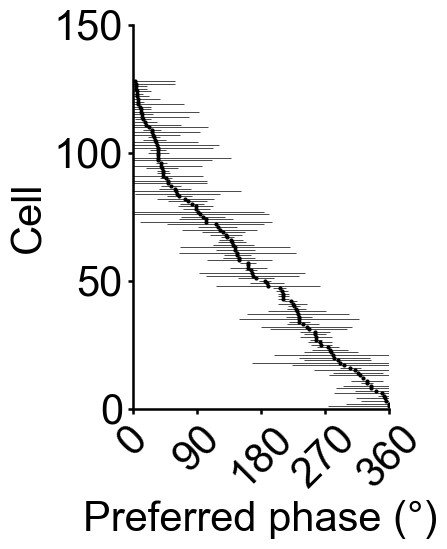

In [135]:
# For cells that respond to more than two spots, plot the mean and standard deviation of preferred phase
plt.errorbar(np.array(mean_max_bin_plot)[sort_indices], np.flipud(np.arange(1,len(mean_max_bin_plot)+1)), xerr = np.array(std_max_bin_plot)[sort_indices], fmt = 'ko', markersize = 2, linewidth = .5)
# cells = [11,91,70,71,5]
# colors = ['lightgreen','goldenrod','m','coral','c']
# for cell_n, cell in enumerate(cells):
#     plot_idx = np.where(sort_indices == cell)[0]
#     plt.plot(plot_idx, np.array(mean_max_bin_plot)[cell],'o', color = colors[cell_n])
plt.xlim(0,360)
plt.ylim(0,150)
plt.xticks([0,90,180,270,360], rotation = 45)
plt.ylabel('Cell')
plt.xlabel('Preferred phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\preferred_tuning_std_sorted.pdf', bbox_inches = 'tight')

In [24]:
# perform 1000 bootstrapped iterations 
n_iters = 1000
# flatten th nested list of preferred phases for each cell 
all_max_phases_flat = [phase for phases in all_max_phases_plot for phase in phases]
bootstrapped_stds = np.empty(n_iters)
for iteration in range(n_iters):
    random.seed(42)
    new_shuffled_std = []
    # shuffle the flattened list of preferred phases 
    random.shuffle(all_max_phases_flat)
    idx = 0
    # for each cell, randomly sample preferred phases from the shuffled array, keeping the dimensions of each list constant
    for cell in all_max_phases_plot:
        grab_n = len(cell)
        # compute the standard deviation of the randomly sampled preferred phases 
        new_shuffled_std.append(scipy.stats.circstd(all_max_phases_flat[idx:idx+grab_n]))
        idx += grab_n
    # for each iteration, save the mean of standard deviations across the population 
    bootstrapped_stds[iteration] = np.mean(np.degrees(new_shuffled_std))

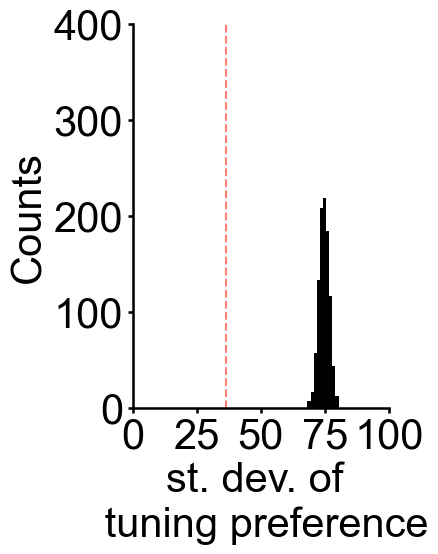

In [137]:
# plot a histogram of the mean standard deviations across 1000 iterations of randomly shuffled preferred phases
# additionally, plot the observed mean 
plt.hist(bootstrapped_stds, color = 'k')
plt.xlim(0,100)
plt.ylim(0,400)
std_mean_observed = np.mean(std_max_bin_plot)
plt.plot([std_mean_observed, std_mean_observed], [0,400], linestyle = '--', color = 'salmon')
plt.xlabel('st. dev. of \n tuning preference')
plt.ylabel('Counts')
plt.xticks(np.arange(0,125,25))
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\preferred_tuning_std_shuffle_control.pdf', bbox_inches = 'tight')

In [26]:
print('mean std observed = ' + str(np.mean(std_max_bin_plot)))
CI = st.t.interval(alpha=0.95, df=len(std_max_bin_plot)-1, loc=np.mean(std_max_bin_plot), scale=st.sem(std_max_bin_plot)) 
print('95% confidence interval = ' + str(np.mean(std_max_bin_plot) - CI[0]))

mean std observed = 36.394517145271024
95% confidence interval = 4.872567803936391


In [27]:
print('mean std shuffled = ' + str(np.mean(bootstrapped_stds)))
CI = st.t.interval(alpha=0.95, df=len(bootstrapped_stds)-1, loc=np.mean(bootstrapped_stds), scale=st.sem(bootstrapped_stds)) 
print('95% confidence interval = ' + str(np.mean(bootstrapped_stds) - CI[0]))

mean std shuffled = 74.76354452513323
95% confidence interval = 0.1274461879824429


In [28]:
# The observed mean does not occur in the bootstrapped distribution. Therefore, we can say that p<.001
print('the observed mean occurs in the bootstrapped distribution ' + str(len(np.where(np.array(bootstrapped_stds)<std_mean_observed)[0])) + ' times')
print('from the bootstrapped analysis, p < .001')

the observed mean occurs in the bootstrapped distribution 0 times
from the bootstrapped analysis, p < .001


### Next, we can measure the correlations between tuning curves measured for significantly activating or significantly suppressing spots

In [46]:
all_activated_cell_tuning_corr = []
all_activated_cell_tuning_corr_shuff = []
for expt in all_phase_expts:
    all_activated_cell_tuning_corr.append(expt['tuning_curve_correlations']['activated_cells'])
    all_activated_cell_tuning_corr_shuff.append(expt['tuning_curve_correlations_shuff']['activated_cells'])

In [47]:
all_activated_cell_tuning_corr = phase_analysis.unravel_list(all_activated_cell_tuning_corr)
all_activated_cell_tuning_corr_shuff = phase_analysis.unravel_list(all_activated_cell_tuning_corr_shuff)

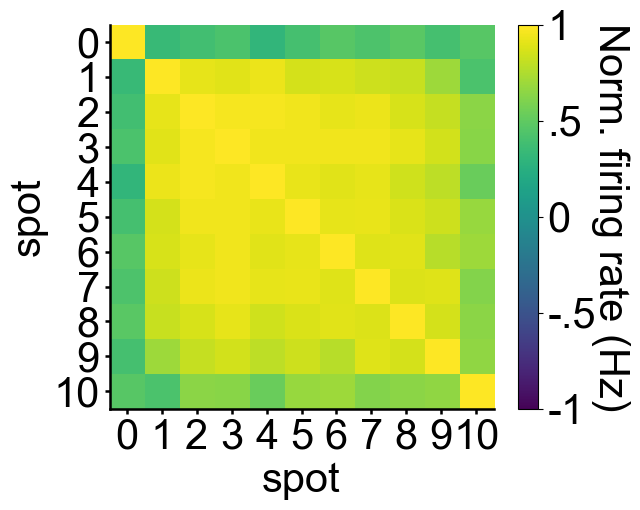

In [139]:
tuning_norm_example_cell = tuning[:,:,13]/np.max(tuning[:,:,13],1)[:,None]
plt.imshow(np.corrcoef(tuning_norm_example_cell))    
plt.xticks(np.arange(0,11));
plt.yticks(np.arange(0,11));
plt.xlabel('spot')
plt.ylabel('spot')
ax = plt.gca()
cbar = plt.colorbar()
plt.clim(-1,1)
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([-1,-.5,0,.5,1])
cbar.ax.set_yticklabels(['-1', '-.5','0','.5','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1, size = 30)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\example_cell_tuning_correlations.pdf', bbox_inches = 'tight')

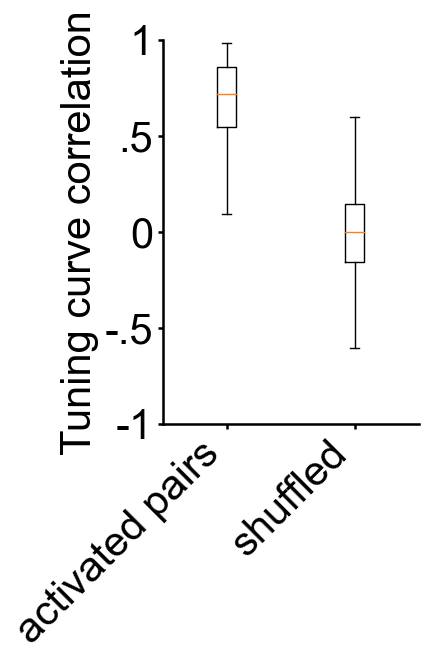

In [142]:
plt.boxplot([all_activated_cell_tuning_corr, all_activated_cell_tuning_corr_shuff], showfliers = False);
plt.ylim(-1,1)
plt.ylabel('Tuning curve correlation')
plt.xticks([1,2], labels = ['activated pairs', 'shuffled'], rotation = 45, ha = 'right')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.yticks([-1,-.5,0,.5,1], labels = ['-1', '-.5', '0', '.5', '1']);
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\tuning_curve_correlations.pdf', bbox_inches = 'tight')

In [141]:
scipy.stats.mannwhitneyu(all_activated_cell_tuning_corr, all_activated_cell_tuning_corr_shuff)

MannwhitneyuResult(statistic=104345.0, pvalue=0.0)

### Let's train a classifier using spot responses to see if we can decode response phase. 

In [147]:
# set the target directory for trial-by-trial spike counts over the 300ms response period for each experiment
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\population_analysis_data')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1\population_analysis_data'

In [148]:
# bin the spike counts by the phase of OB stimulation. For each phase bin, we will use the first 15 trials of stimulation. 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    binned_spike_counts = phase_analysis.bin_spike_counts_by_phase(phase_expt['trial_type_spike_counts'], phase_expt['bin_indices_all'], max_trial = 15)
    all_phase_expts.append(np.array(binned_spike_counts))

In [149]:
# set some useful parameters
n_spots = all_phase_expts[0].shape[0] # 11 spots (10 and 1 blank)
n_bins = all_phase_expts[0].shape[1] # 20 bins
n_trials = 15 # hard-coded, we will analyze the first 15 trials of each stimulation-phase for each spot

In [150]:
# concatenate cells across experiments for all spots (excluding the blank)
all_phase_expts_spot_cat = all_phase_expts[0][1:,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat = np.concatenate((all_phase_expts_spot_cat, expt[1:,:,:,:]), axis = 2)

In [151]:
# rearrange the axes so we end up with an n_bins x (n_spots x n_trials) x n_cells array. This gives us 150 trials per spot bin. 
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat, (2,3), (3,2))
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat_arranged, (0,1), (1,0))
all_phase_expts_spot_cat_reshaped = np.reshape(all_phase_expts_spot_cat_arranged,
                                               (all_phase_expts_spot_cat_arranged.shape[0],all_phase_expts_spot_cat_arranged.shape[1]*all_phase_expts_spot_cat_arranged.shape[2],all_phase_expts_spot_cat_arranged.shape[3]))

In [152]:
# reshape the training data in n_instances(150*20) x n_features(519). create a labels array with 150 trials per phase bin. 
train_data = np.reshape(all_phase_expts_spot_cat_reshaped, (all_phase_expts_spot_cat_reshaped.shape[0]*all_phase_expts_spot_cat_reshaped.shape[1],all_phase_expts_spot_cat_reshaped.shape[2]))
labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])

In [153]:
# Now, let's train an svm classifier using this data 
X_train = train_data
y_train = labels 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx_spots = conf_mx/row_sums

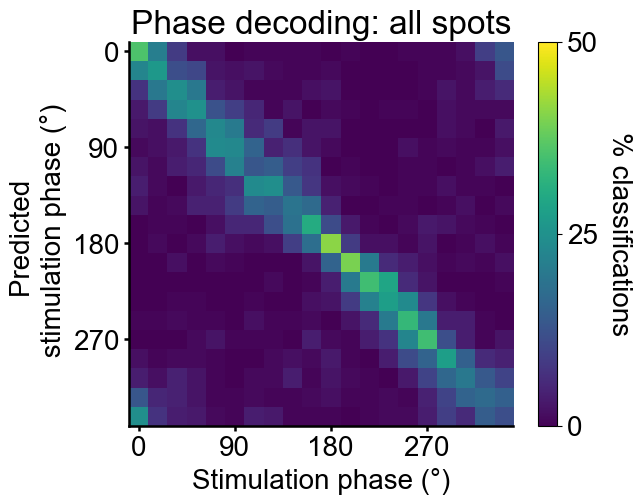

In [154]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(conf_mx_spots)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_all_spots.pdf', bbox_inches = 'tight')

### Next, we will train a classifier using the blank condition to see how breathing alone affects firing rates

In [155]:
# Concatenate all of the cell responses in the blank condition (spot 0)
spot = 0
all_phase_expts_spot_cat_blank = all_phase_expts[0][spot,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat_blank = np.concatenate((all_phase_expts_spot_cat_blank, expt[spot,:,:,:]), axis = 1)
    
# rearrange and reshape the matrix, get phase labels for each trial
trial_type_phase_binned_spike_counts_move = np.moveaxis(all_phase_expts_spot_cat_blank, (0,1), (1,0))
spike_counts_reshaped, labels, stim_idxs = PGanalysis.spike_shaper_2d(trial_type_phase_binned_spike_counts_move)

# Train and test the classifier using 5-fold cross-validation
X_train = spike_counts_reshaped
y_train = labels 
svm_clf = SVC(kernel = 'linear')
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx_blank = confusion_matrix(y_train, y_train_pred)

# divide by the number of trials in the corresponding class
row_sums_blank = conf_mx_blank.sum(axis = 1, keepdims = True)
conf_mx_blank = conf_mx_blank/row_sums_blank

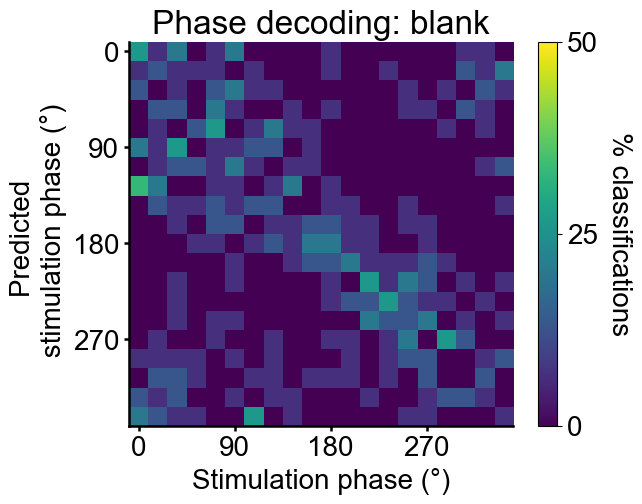

In [156]:
# plot the phase classification accuracy for blank trials
plt.imshow(conf_mx_blank)
plt.title('Phase decoding: blank')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_decoding_blank.pdf', bbox_inches = 'tight')

### Let's test generalization performance across spots

In [157]:
# reshape the training data in n_instances(150*20) x n_features(519). create a labels array with 150 trials per phase bin. 
train_data = np.reshape(all_phase_expts_spot_cat_reshaped, (all_phase_expts_spot_cat_reshaped.shape[0]*all_phase_expts_spot_cat_reshaped.shape[1],all_phase_expts_spot_cat_reshaped.shape[2]))
labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])

In [158]:
# Here, we will use the same training data and labels as in the initial phase classifier. 
groups = []
for bin_ in range(n_bins):
    groups.append(np.repeat(np.arange(n_spots-1),n_trials))
groups = np.array([group for bin_ in groups for group in bin_])

In [159]:
# We will use GroupKFold to assess generalization performance. This allows us to split the training data into a set of training groups and a held-out group. 
from sklearn.model_selection import GroupKFold

# We will split the data into 10 different groups
group_kfold = GroupKFold(n_splits=n_spots-1)

# Save the 10 matrices that will be generated
generalize_conf_mx = np.empty((n_spots-1, n_bins, n_bins))
for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, labels, groups)):
    
    # define the train and test sets 
    X_train = train_data[train_index,:]
    X_test = train_data[test_index,:]
    y_train = labels[train_index]
    y_test = labels[test_index]
    
    # train the SVM
    svm_clf = SVC(kernel = 'linear')
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    conf_mx = confusion_matrix(y_test, y_pred)
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    conf_mx = conf_mx/row_sums
    
    # save the output 
    generalize_conf_mx[i,:,:] = conf_mx

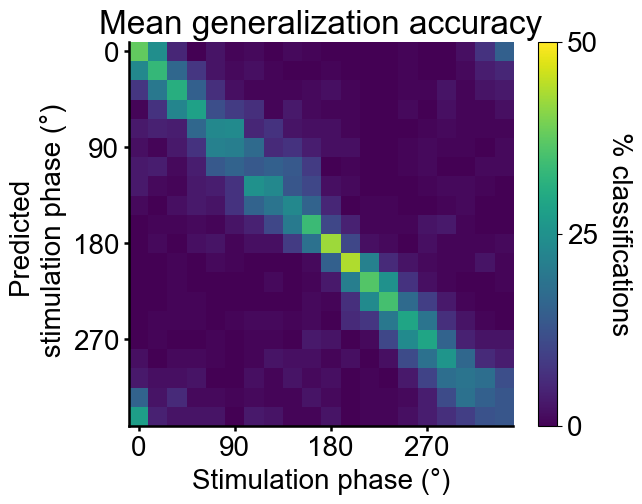

In [160]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(np.mean(generalize_conf_mx,0))
plt.title('Mean generalization accuracy')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\mean_generalization_accuracy.pdf', bbox_inches = 'tight')

In [78]:
# Here, we will shift each row of the matrix so that the correct bin is centered.
# Do this for phase decoding and blank analyses
t = np.arange((n_spots-1),(n_spots-1)*-1,-1)
rolled_mat_spots = np.zeros_like(conf_mx_spots)
rolled_mat_blank = np.zeros_like(conf_mx_blank)
for roll_n, roll in enumerate(t):
    rolled_mat_spots[roll_n,:] = np.roll(conf_mx_spots[roll_n,:],roll)
    rolled_mat_blank[roll_n,:] = np.roll(conf_mx_blank[roll_n,:],roll)

In [79]:
# Perform the same analysis for each iteration of the generalization decoding
t = np.arange((n_spots-1),(n_spots-1)*-1,-1)
generalization_rolled_mats = np.empty((len(generalize_conf_mx), generalize_conf_mx[0].shape[0]))
rolled_mat = np.zeros_like(generalize_conf_mx[0])
for conf_mx_n, conf_mx in enumerate(generalize_conf_mx):
    for roll_n, roll in enumerate(t):
        rolled_mat[roll_n,:] = np.roll(conf_mx[roll_n,:],roll)
    generalization_rolled_mats[conf_mx_n, :] = np.mean(rolled_mat,0)

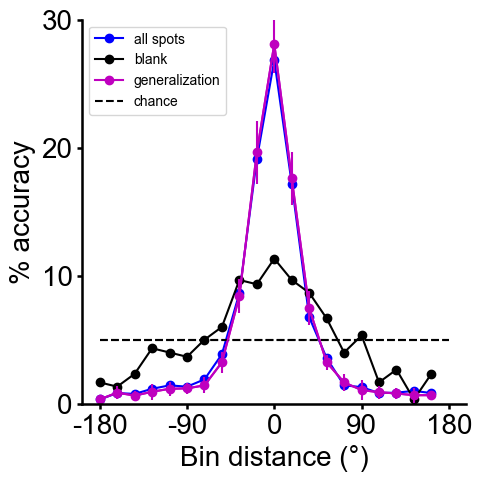

In [161]:
# plot classifier accuracy as a function of bin distance 
plt.plot(np.mean(rolled_mat_spots,0),'-bo', label = 'all spots')
plt.plot(np.mean(rolled_mat_blank,0),'-ko', label = 'blank')
plt.ylim(0,.3)
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

plt.plot(np.mean(generalization_rolled_mats,0),'m-o',label = 'generalization')

CI = []
for bin_ in range(20):
    data = generalization_rolled_mats[:,bin_]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    CI.append(t[1]-np.mean(data))
plt.errorbar(np.arange(20),np.mean(generalization_rolled_mats, 0), yerr = CI, color = 'm')

plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
plt.plot([0,20],[1/20, 1/20], 'k--', label = 'chance')
plt.legend(loc = 'upper left', fontsize = 10)
PGanalysis.axis_fixer(ratio = 1, size = 30)
#plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig1\fig1_final\phase_blank_generalization_decoding.pdf', bbox_inches = 'tight')